```{include} ../math-definitions.md
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
from scipy.stats import t as t_Student
from joblib import Parallel, delayed

plt.style.use('seaborn')

# Series con raíz unitaria y procesos ARIMA

## Series con raíz unitaria

La caminata aleatoria (con o sin deriva) puede verse como un modelo AR(1) en el cual la raíz del polinomio de rezagos es uno:
\begin{align*}
y_t &= c + y_{t-1} + \epsilon_t \\
(1-\Lag)y_t &= c + \epsilon_{t}
\end{align*}

Por ello, en general decimos que un proceso con tendencia estocástica tiene raíz unitaria.

Consideremos el siguiente proceso AR(2)
\begin{equation*}
y_t = 0.6y_{t-1} + 0.4y_{t-2} + \epsilon_{t}
\end{equation*}

Su polinomio de rezagos es $1-0.6\Lag - 0.4\Lag^2 = (1-0.4\Lag)(1-1\Lag)$, cuyas raíces son 1 y 2.5. Es decir, este proceso también tiene una raíz unitaria, y por tanto no es estacionario.

La factorización del polinomio de rezagos nos sugiere escribir
\begin{align*}
	(1-0.4\Lag)(1-1\Lag)y_t & =\epsilon_{t}                       \\
	(1-0.4\Lag)\Delta y_t           & =\epsilon_{t}                       \\
	\Delta y_t                      & = 	0.4\Delta y_{t-1} + \epsilon_{t}
\end{align*}

Visto como un proceso para $y^*\equiv\Delta y_t$, este es un proceso AR(1) estacionario.



## Procesos ARIMA(p,d,q)

En el ejemplo anterior, como la primera diferencia de $y_t$ es un proceso AR(1) estacionario, decimos que $y_t$ es un proceso ARIMA(1,1,0).

En general, si un proceso integrado de orden $d$, $y_t$, es diferenciado $d$ veces y su resultado  $\Delta^d y_t$  es un proceso ARMA(p,q), entonces decimos que $y_t$ tiene un proceso ARIMA(p,d,q):

\{admonition} Autorregresivo integrado de media móvil: ARIMA
Sea $\left\{\epsilon_t\right\}$ ruido blanco; el proceso estocástico \vspace{-0.5em}
\begin{equation*}
\Phi(\Lag)(1-\Lag)^d y_t = \Theta(\Lag)\epsilon_t
\end{equation*}

\vspace{-0.5em} es llamado proceso ARIMA(p,d,q), donde $\Phi(\Lag)$ es un polinomio de grado $p$ cuyas raíces están fuera del círculo unitario, y $\Theta(\Lag)$ es un polinomio de grado $q$.



## Repaso del modelo clásico de regresión lineal

En el modelo clásico de regresión lineal se tiene
\begin{equation*}
y_i = \beta_1x_{1,i} + \beta_2x_{2,i} + \dots + \beta_kx_{k,i} + \epsilon_i
\end{equation*}
donde $\epsilon_i\sim N(0,\sigma^2)$ es un error homoscedástico y no-autocorrelacionado.

Si se cumplen los supuestos del MCRL, este modelo se puede estimar de manera insesgada y eficiente por medio del estimador mínimos cuadrados ordinarios.

Para hacer un test sobre un parámetro
\begin{align*}
H_0:\quad \beta_j &= q &
H_1:\quad \beta_j &\neq q
\end{align*}

utilizamos el valor estimado por mínimos cuadrados ordinarios $\hat{\beta}_j$ y su error estándar $s.e.(\beta_j)$, y decimos que **si la hipótesis nula es cierta** entonces el estadístico

\begin{equation*}
\frac{\hat{\beta}_j - q}{s.e.(\beta_j)} \sim t_{n-k}
\end{equation*}
(tiene una distribución $t$-Student con $n-k$ grados de libertad, donde $n$ es el número de observaciones y $k$ el número de parámetros estimados).


Es decir, con un nivel de significancia $\alpha$, el intervalo
\begin{equation*}
\left[q + t_{\alpha/2}s.e.(\beta_j),\; q + t_{1-\alpha/2}s.e.(\beta_j)\right]
\end{equation*}
contendrá al valor estimado $\hat{\beta}_j$ en $100(1-\alpha)\%$ de las muestras **siempre y cuando sea cierto que $\beta_j=q$**.

Por ello, cuando encontramos un valor $\hat{\beta}_j$ que no está contenido en ese intervalo, rechazamos la hipótesis nula, y decimos que $\beta_j$ es significativamente distinto de $q$, **a sabiendas de que nuestro procedimiento incurrirá en el error tipo-1 (rechazar una hipotésis verdadera) en $100\alpha\%$ de las muestras**.

Para que este procedimiento tenga validez, es necesario que el estadístico efectivamente tenga la distribución $t$-Student, lo cual es cierto **siempre que se cumplan los supuestos del modelo clásico de regresión lineal**.


## Regresión espuria

En 1974, Granger y Newbold demostraron, via simulaciones, que si una serie I(1) se estima en función de otra serie I(1) completamente independiente de ella, los estadísticos usuales tenderán a mostar que las dos series están relacionadas.

Es decir, si $y_t, x_t$ son dos series I(1) independientes, al correr la regresión
\begin{equation*}
y_t = \beta_0 + \beta_1 x_t + \epsilon_{t}
\end{equation*}
fallaríamos en rechazar la hipótesis nula $\beta_1 = 0$ (la cual es cierta porque $y_t$ no depende de $x_t$) con una frecuencia mayor a la que sugiere la distribución $t$-student correspondiente:
\begin{equation*}
\frac{\hat{\beta}_{1}}{\hat{s.e}(\beta_1)} \sim t_{T-2} \quad\Leftarrow\text{¡ya no es cierto!}
\end{equation*}

Este fenómeno de encontrar relaciones inexistentes entre variables integradas se conoce como **regresión espuria**.



{{ empieza_ejemplo }} Replicando Granger y Newbold 1974 {{ fin_titulo_ejemplo }}
<!-- Basado en Levendis pp117-121 -->

\begin{align*}
y_t &= 0.25 + y_{t-1} + \epsilon^y_t \\
x_t &= 0.25 + x_{t-1} + \epsilon^x_t
\end{align*}

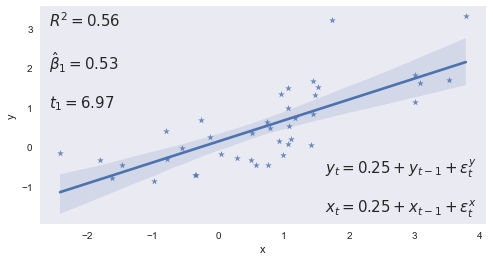

In [2]:
np.random.seed(240)
e = np.random.randn(40,2)

df = pd.DataFrame(
    (0.25+e).cumsum(axis=1),
    columns=['y', 'x']
    )

res = smf.ols("y ~ x" , df).fit()

fig, ax = plt.subplots(figsize=[8,4])
sns.regplot(x='x',y='y',data=df, marker='*',ax=ax)
ax.set(xlabel='x', ylabel='y')

statslabel = f'$R^2={res.rsquared:.2f}$'
statslabel += f'\n\n$\\hat\\beta_1={res.params[1]:.2f}$'
statslabel += f'\n\n$t_1={res.tvalues[1]:.2f}$'
ax.annotate(statslabel, (0.02,0.98), xycoords='axes fraction', size=15, va='top')

modellabel = r'$y_t = 0.25 + y_{t-1} + \epsilon^y_t$'
modellabel += '\n\n$x_t = 0.25 + x_{t-1} + \\epsilon^x_t$'
ax.annotate(modellabel, (0.98,0.02), xycoords='axes fraction', size=15, va='bottom',ha='right')
ax.grid(False);

In [3]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     48.60
Date:                Thu, 21 Jul 2022   Prob (F-statistic):           2.69e-08
Time:                        00:15:57   Log-Likelihood:                -40.091
No. Observations:                  40   AIC:                             84.18
Df Residuals:                      38   BIC:                             87.56
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1400      0.119      1.174      0.248      -0.101       0.381
x              0.5325      0.076      6.972      0.000       0.378       0.687
==============================================================================
Omnibus:                        7.474   Durbin-Watson:                   2.329
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                6.173
Skew:                           0.843   Prob(JB):                       0.0457
Kurtosis:                       3.929   Cond. No.                         1.94
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Experimento de Monte Carlo para determinar la distribución del estadítico t**

CPU times: total: 51.7 s
Wall time: 2min 7s


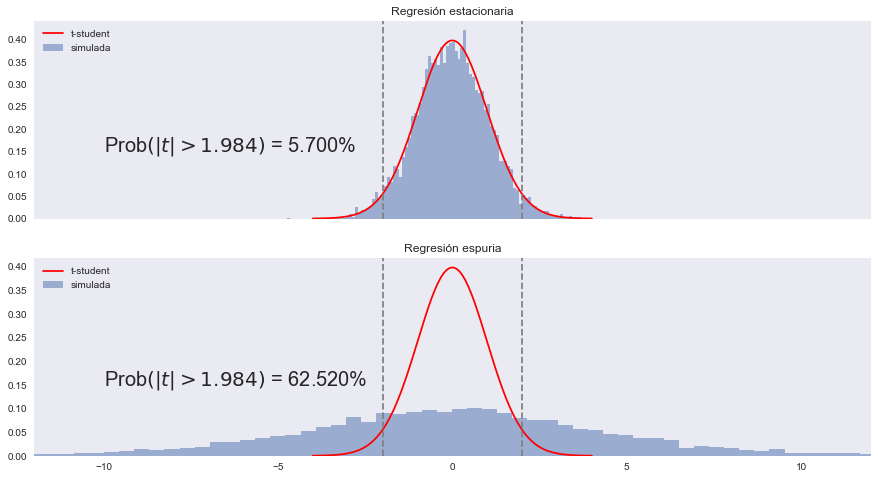

In [4]:
%%time
def regresion(T=40):
    e = np.random.randn(2, T)

    df = pd.DataFrame(dict(
        x = e[0].cumsum(),
        y = e[1].cumsum(),
        u = e[0],
        v = e[1]
        ),
        columns=['x', 'y', 'u', 'v']
        )

    t_estacionario = smf.ols("v~u", data=df).fit().tvalues[1]
    t_espurio = smf.ols("y~x", data=df).fit().tvalues[1]
    return t_estacionario, t_espurio

def Monte_Carlo(funcion, repeticiones, columns, *args, **kwargs):
    datos = Parallel(n_jobs=-1)(delayed(funcion)(*args, **kwargs) for _ in range(repeticiones))
    return pd.DataFrame(datos, columns=columns)


N = 10_000
np.random.seed(12345)
tvalues = Monte_Carlo(regresion, N, ['estacionaria', 'espuria'])


maxtval = 12
t5crit = t_Student.isf(0.05/2, 98)


fig, (ax0,ax1) = plt.subplots(2,1,figsize=[15, 8], sharex=True)


def plot_simulated(caso, ax):
    ff, edges = np.histogram(tvalues[caso], bins=100, density=True)
    center = (edges[1:] + edges[:-1])/2
    w = center[1] - center[0]

    ax.bar(center, ff, width=w, alpha=0.5)
    xvals = np.linspace(-4,4, 200)
    ax.plot(xvals, t_Student.pdf(xvals, df=98), '-r')
    ax.set(xlim=[-maxtval, maxtval], title=f'Regresión {caso}')
    ax.legend(['t-student', 'simulada'], loc='upper left')

    # valores críticos
    opciones = dict(ls="--", color='gray')
    ax.axvline(t5crit, **opciones)
    ax.axvline(-t5crit, **opciones)

    # error tipo I
    err1 = (tvalues[caso].abs() > t5crit).mean()*100
    ax.annotate(f'Prob$\\left(|t| > 1.984\\right)$ = {err1:.3f}%', (-10,0.15), size=20)

    ax.grid(False)

    
plot_simulated('estacionaria', ax0)
plot_simulated('espuria', ax1)

{{ termina_ejemplo }}




## Regresión lineal con series integradas
**¿Cómo estudiar la relación entre series integradas sin incurrir en regresiones espurias?**

Supongamos que tanto $y_t$ como $x_t$ son series I(1).

Entonces, por definición, $\Delta y_t$ y $\Delta x_t$ son series estacionarias.

En tal caso, el modelo
\begin{equation*}
\Delta y_t = \beta_0 + \beta_1\Delta x_t + \epsilon_t
\end{equation*}
puede estimarse por mínimos cuadrados, y la prueba $\beta_1=0$ se realiza usando el procedimiento usual.

Una alternativa mejor, que estudiaremos con detalladamente más tarde en el curso, es estimar la regresión en niveles
\begin{equation*}
y_t = \beta_0 + \beta_1 x_t + \epsilon_t
\end{equation*}
y determinar si los residuos de esta regresión son estacionarios. Si lo son, diremos que $y_t$ está cointegrada con $x_t$.



## Procesos AR(p) con raíz unitaria

Recordemos que el proceso AR(p) puede escribirse

\begin{align*}
	y_t  & = c + \phi_1 y_{t-1} +\dots + \phi_p y_{t-p} +  \epsilon_t \\
\left(1 - \phi_1\Lag^1 -\dots - \phi_p\Lag^p\right)y_{t} & = c +  \epsilon_t \\
\Phi(\Lag)y_{t}                                          & = c +  \epsilon_t
\end{align*}

Supongamos que los coeficientes autorregresivos suman uno. Entonces
\begin{align*}
\Phi(1) &= 1 - \phi_1 1^1 -\dots - \phi_p 1^p\\
        &= 1 - (\phi_1 + \phi_2 + \dots + \phi_p) = 1 - 1 = 0
\end{align*}

Es decir, si $\phi_1 + \phi_2 + \dots + \phi_p=1$, entonces el proceso tiene raíz unitaria.